In [81]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Data Selection

At first, we wanted to sort through wine data to create a model that could essentially do some of the work of sommeliers. After not finding data with which we were satisfied, we thought about looking into whiskey or beer. Still, we weren't satisfied. We quickly realized that coffee culture has been picking up, and as coffee aficionados, we realized this would be the perfect topic. Thanks to James LeDoux (https://github.com/jldbc/coffee-quality-database), we found a plethora of data regarding coffee quality scores and various features, most of which was sourced from the Coffee Quality Institute (https://database.coffeeinstitute.org/coffees/arabica). We also sourced price data from the International Coffee Organization (http://www.ico.org/new_historical.asp).

# Data Cleaning

In [82]:
df_pre_cleaning = pd.read_csv('data/arabica_ratings_raw.csv')

In [83]:
df_pre_cleaning.shape

(1312, 53)

In [84]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [85]:
df_pre_cleaning.head()

,Unnamed: 0,quality_score,view_certificate_1,view_certificate_2,Cupping Protocol and Descriptors,View Green Analysis Details,Request a Sample,Species,Owner,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,Producer,Number of Bags,Bag Weight,In-Country Partner,Harvest Year,Grading Date,Owner.1,Variety,Status,Processing Method,NA,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,NA.1,Uniformity,Clean Cup,Sweetness,Cupper Points,Total Cup Points,NA.2,Moisture,Category One Defects,Quakers,Color,Category Two Defects,NA.3,Expiration,Certification Body,Certification Address,Certification Contact,Unnamed: 51,Notes
0,0,90.58,NaN,NaN,NaN,NaN,NaN,Arabica,metad plc,Ethiopia,METAD PLC,NaN,METAD PLC,2014/2015,METAD Agricultural Developmet plc,1950-2200,GUJI-HAMBELA/GOYO,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,NaN,Completed,Washed / Wet,Sample,8.67,8.83,8.67,8.75,8.50,8.42,Sample,10.0,10.0,10.0,8.75,Sample 90.58,NaN,12 %,0 full defects,0.0,Green,0 full defects,NaN,"April 3rd, 2016",METAD Agricultural Development plc,"BAWA Center, 3rd Floor (Gerji), Addis Ababa, Ethiopia","Aman Adinew (Emebet Dinku) - +251-116-292534, +251-911-519196",NaN,NaN
1,1,89.92,NaN,NaN,NaN,NaN,NaN,Arabica,metad plc,Ethiopia,METAD PLC,NaN,METAD PLC,2014/2015,METAD Agricultural Developmet plc,1950-2200,GUJI-HAMBELA/ALAKA,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Completed,Washed / Wet,Sample,8.75,8.67,8.50,8.58,8.42,8.42,Sample,10.0,10.0,10.0,8.58,Sample 89.92,NaN,12 %,0 full defects,0.0,Green,1 full defects,NaN,"April 3rd, 2016",METAD Agricultural Development plc,"BAWA Center, 3rd Floor (Gerji), Addis Ababa, Ethiopia","Aman Adinew (Emebet Dinku) - +251-116-292534, +251-911-519196",NaN,NaN
2,2,89.75,NaN,NaN,NaN,NaN,NaN,Arabica,Grounds for Health Admin,Guatemala,"San Marcos Barrancas ""San Cristobal Cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,NaN,5,1,Specialty Coffee Association,NaN,"May 31st, 2010",Grounds for Health Admin,Bourbon,Completed,NaN,Sample,8.42,8.50,8.42,8.42,8.33,8.42,Sample,10.0,10.0,10.0,9.25,Sample 89.75,NaN,0 %,0 full defects,0.0,NaN,0 full defects,NaN,"May 31st, 2011",Specialty Coffee Association,"117 W 4th St, Suite 300 Santa Ana, CA 92701",Chris Buck - (562) 624-4100,NaN,NaN
3,3,89.00,NaN,NaN,NaN,NaN,NaN,Arabica,Yidnekachew Dabessa,Ethiopia,Yidnekachew Dabessa Coffee Plantation,NaN,Wolensu,NaN,Yidnekachew Debessa Coffee Plantation,1800-2200,Oromia,Yidnekachew Dabessa Coffee Plantation,320,60 kg,METAD Agricultural Development plc,2014,"March 26th, 2015",Yidnekachew Dabessa,NaN,Completed,Natural / Dry,Sample,8.17,8.58,8.42,8.42,8.50,8.25,Sample,10.0,10.0,10.0,8.67,Sample 89.00,NaN,11 %,0 full defects,0.0,Green,2 full defects,NaN,"March 25th, 2016",METAD Agricultural Development plc,"BAWA Center, 3rd Floor (Gerji), Addis Ababa, Ethiopia","Aman Adinew (Emebet Dinku) - +251-116-292534, +251-911-519196",NaN,NaN
4,4,88.83,NaN,NaN,NaN,NaN,NaN,Arabica,metad plc,Ethiopia,METAD PLC,NaN,METAD PLC,2014/2015,METAD Agricultural Developmet plc,1950-2200,GUJI-HAMBELA/BISHAN FUGU,METAD PLC,300,60 kg,METAD Agricultural Development plc,2014,"April 4th, 2015",metad plc,Other,Completed,Washed / Wet,Sample,8.25,8.50,8.25,8.50,8.42,8.33,Sample,10.0,10.0,10.0,8.58,Sample 88.83,NaN,12 %,0 full defects,0.0,Green,2 full defects,NaN,"April 3rd, 2016",METAD Agricultural Development plc,"BAWA Center, 3rd Floor (Gerji), Addis Ababa, Ethiopia","Aman Adinew (Emebet Dinku) - +251-116-292534, +251-911-519196",NaN,NaN


###### Key Cleaning Steps: 
* Dropped any row missing more than four features that we could not fill in (ie. region) 
* Analyzed column value counts and dropped columns with categorical data that had a large number of unique categories, which we feared could lead to overfitting our model 
* Merged price data with initial dataset based on harvest year and country. Ultimately, dropped this column due to missing countries/years in price data 
* Removed excess characters from moisture and defect columns to convert data types to floats
* Created a year column using the grading date year. We initially wanted to use the harvest year data, but we had too many missing values 
* Used regex to clean altitude column. The initial altitude values are seen below. For data points with missing altitude, set altitude equal to the regions average. In cases where the region was unique, we used the country average 

In [86]:
df_pre_cleaning['Altitude']

0       1950-2200                    
1       1950-2200                    
2       1600 - 1800 m                
3       1800-2200                    
4       1950-2200                    
5       NaN                          
6       NaN                          
7       1570-1700                    
8       1570-1700                    
9       1795-1850                    
10      1855-1955                    
11      Meters above sea level: 1.872
12      Meters above sea level: 1.943
13      2000 ft                      
14      1570-1700                    
15      Meters above sea level: 2.080
16      1200-1800m                   
17      NaN                          
18      1450                         
19      1700-2000m                   
20      Meters above sea level: 2.019
21      1300 MSNM                    
22      1320                         
23      Meters above sea level: 2.112
24      NaN                          
25      1250m                        
26      NaN 

In [87]:
df['final_final_alt']

0       0.306558
1       0.306558
2       0.294526
3       0.306558
4       0.932632
5       0.976316
6       0.958947
7       0.996316
8       0.307360
9       0.736842
10      0.947368
11      0.297574
12      0.657895
13      0.668421
14      0.312493
15      0.881579
16      0.631579
17      1.000000
18      0.605263
19      0.657895
20      0.657895
21      0.907895
22      0.921053
23      0.320926
24      0.995263
25      0.657895
26      0.500000
27      0.896842
28      0.631579
29      0.907895
          ...   
1102    0.605263
1103    0.552632
1104    0.647368
1105    0.421053
1106    0.763158
1107    0.631579
1108    0.668086
1109    0.668086
1110    0.868421
1111    0.320926
1112    0.663495
1113    0.573684
1114    0.605263
1115    0.631579
1116    0.320926
1117    0.684211
1118    0.605263
1119    0.320926
1120    0.605263
1121    0.394737
1122    0.921053
1123    0.500000
1124    0.532912
1125    0.736842
1126    0.736842
1127    0.736842
1128    0.447368
1129    0.1578

# Feature Engineering

In [88]:
df = pd.read_csv('data/final_df.csv')

In [89]:
df = df.drop(['Unnamed: 0'], axis=1)

In [90]:
df.shape

(1132, 20)

In [91]:
df.head()

,Country of Origin,In-Country Partner,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Moisture,Category One Defects,Quakers,Category Two Defects,year,target,final_final_alt
0,ethiopia,metad agricultural development plc,washed / wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,12,0,0.0,0,2015,1.0,632.46
1,ethiopia,metad agricultural development plc,washed / wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,12,0,0.0,1,2015,1.0,632.46
2,ethiopia,metad agricultural development plc,natural / dry,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,11,0,0.0,2,2015,1.0,609.60
3,ethiopia,metad agricultural development plc,washed / wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,12,0,0.0,2,2015,1.0,632.46
4,ethiopia,metad agricultural development plc,natural / dry,8.08,8.58,8.50,8.50,7.67,8.42,10.0,10.0,10.0,8.50,10,0,0.0,4,2015,1.0,1822.00


In [92]:
#get dummies
df = pd.get_dummies(df)

In [93]:
df.shape

(1132, 81)

In [94]:
df.head()

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Moisture,Category One Defects,Quakers,Category Two Defects,year,target,final_final_alt,Country of Origin_brazil,Country of Origin_burundi,Country of Origin_china,Country of Origin_colombia,Country of Origin_costa rica,Country of Origin_cote d?ivoire,Country of Origin_ecuador,Country of Origin_el salvador,Country of Origin_ethiopia,Country of Origin_guatemala,Country of Origin_haiti,Country of Origin_honduras,Country of Origin_indonesia,Country of Origin_japan,Country of Origin_kenya,Country of Origin_laos,Country of Origin_malawi,Country of Origin_mexico,Country of Origin_myanmar,Country of Origin_nicaragua,Country of Origin_panama,Country of Origin_papua new guinea,Country of Origin_peru,Country of Origin_philippines,Country of Origin_rwanda,Country of Origin_taiwan,"Country of Origin_tanzania, united republic of",Country of Origin_thailand,Country of Origin_uganda,Country of Origin_united states,Country of Origin_united states (hawaii),Country of Origin_united states (puerto rico),Country of Origin_vietnam,Country of Origin_zambia,In-Country Partner_africa fine coffee association,In-Country Partner_almacafé,In-Country Partner_amecafe,In-Country Partner_asociacion nacional del café,In-Country Partner_asociación de cafés especiales de nicaragua,In-Country Partner_asociación mexicana de cafés y cafeterías de especialidad a.c.,In-Country Partner_blossom valley international,In-Country Partner_blossom valley international,In-Country Partner_brazil specialty coffee association,In-Country Partner_centro agroecológico del café a.c.,In-Country Partner_coffee quality institute,In-Country Partner_instituto hondureño del café,In-Country Partner_kenya coffee traders association,In-Country Partner_metad agricultural development plc,In-Country Partner_nucoffee,In-Country Partner_salvadoran coffee council,In-Country Partner_specialty coffee ass,In-Country Partner_specialty coffee association,In-Country Partner_specialty coffee association of costa rica,In-Country Partner_specialty coffee association of indonesia,In-Country Partner_specialty coffee institute of asia,In-Country Partner_tanzanian coffee board,In-Country Partner_torch coffee lab yunnan,In-Country Partner_uganda coffee development authority,In-Country Partner_yunnan coffee exchange,Processing Method_natural / dry,Processing Method_other,Processing Method_pulped natural / honey,Processing Method_semi-washed / semi-pulped,Processing Method_washed / wet
0,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,12,0,0.0,0,2015,1.0,632.46,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,12,0,0.0,1,2015,1.0,632.46,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,11,0,0.0,2,2015,1.0,609.60,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,12,0,0.0,2,2015,1.0,632.46,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,8.08,8.58,8.50,8.50,7.67,8.42,10.0,10.0,10.0,8.50,10,0,0.0,4,2015,1.0,1822.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [95]:
# scale features using min-max scaler - chose min-max scaler because of very small standard deviations for numerical data and majority appeared normally distributed
for col in df.columns:
    df[col] = (df[col]-min(df[col]))/ (max(df[col]) - min(df[col]))

In [96]:
df.head()

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Moisture,Category One Defects,Quakers,Category Two Defects,year,target,final_final_alt,Country of Origin_brazil,Country of Origin_burundi,Country of Origin_china,Country of Origin_colombia,Country of Origin_costa rica,Country of Origin_cote d?ivoire,Country of Origin_ecuador,Country of Origin_el salvador,Country of Origin_ethiopia,Country of Origin_guatemala,Country of Origin_haiti,Country of Origin_honduras,Country of Origin_indonesia,Country of Origin_japan,Country of Origin_kenya,Country of Origin_laos,Country of Origin_malawi,Country of Origin_mexico,Country of Origin_myanmar,Country of Origin_nicaragua,Country of Origin_panama,Country of Origin_papua new guinea,Country of Origin_peru,Country of Origin_philippines,Country of Origin_rwanda,Country of Origin_taiwan,"Country of Origin_tanzania, united republic of",Country of Origin_thailand,Country of Origin_uganda,Country of Origin_united states,Country of Origin_united states (hawaii),Country of Origin_united states (puerto rico),Country of Origin_vietnam,Country of Origin_zambia,In-Country Partner_africa fine coffee association,In-Country Partner_almacafé,In-Country Partner_amecafe,In-Country Partner_asociacion nacional del café,In-Country Partner_asociación de cafés especiales de nicaragua,In-Country Partner_asociación mexicana de cafés y cafeterías de especialidad a.c.,In-Country Partner_blossom valley international,In-Country Partner_blossom valley international,In-Country Partner_brazil specialty coffee association,In-Country Partner_centro agroecológico del café a.c.,In-Country Partner_coffee quality institute,In-Country Partner_instituto hondureño del café,In-Country Partner_kenya coffee traders association,In-Country Partner_metad agricultural development plc,In-Country Partner_nucoffee,In-Country Partner_salvadoran coffee council,In-Country Partner_specialty coffee ass,In-Country Partner_specialty coffee association,In-Country Partner_specialty coffee association of costa rica,In-Country Partner_specialty coffee association of indonesia,In-Country Partner_specialty coffee institute of asia,In-Country Partner_tanzanian coffee board,In-Country Partner_torch coffee lab yunnan,In-Country Partner_uganda coffee development authority,In-Country Partner_yunnan coffee exchange,Processing Method_natural / dry,Processing Method_other,Processing Method_pulped natural / honey,Processing Method_semi-washed / semi-pulped,Processing Method_washed / wet
0,0.978202,1.000000,1.000,1.000000,1.000000,0.936,1.0,1.0,1.0,1.000000,0.705882,0.0,0.0,0.000000,0.998504,1.0,0.306558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.941818,0.932,0.951429,0.963134,0.936,1.0,1.0,1.0,0.952514,0.705882,0.0,0.0,0.018182,0.998504,1.0,0.306558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.841962,0.909091,0.900,0.905714,1.000000,0.868,1.0,1.0,1.0,0.977654,0.647059,0.0,0.0,0.036364,0.998504,1.0,0.294526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.863760,0.880000,0.832,0.928571,0.963134,0.900,1.0,1.0,1.0,0.952514,0.705882,0.0,0.0,0.036364,0.998504,1.0,0.306558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# Exploratory Data Analysis (EDA)

In [97]:
df.describe()

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Moisture,Category One Defects,Quakers,Category Two Defects,year,target,final_final_alt,Country of Origin_brazil,Country of Origin_burundi,Country of Origin_china,Country of Origin_colombia,Country of Origin_costa rica,Country of Origin_cote d?ivoire,Country of Origin_ecuador,Country of Origin_el salvador,Country of Origin_ethiopia,Country of Origin_guatemala,Country of Origin_haiti,Country of Origin_honduras,Country of Origin_indonesia,Country of Origin_japan,Country of Origin_kenya,Country of Origin_laos,Country of Origin_malawi,Country of Origin_mexico,Country of Origin_myanmar,Country of Origin_nicaragua,Country of Origin_panama,Country of Origin_papua new guinea,Country of Origin_peru,Country of Origin_philippines,Country of Origin_rwanda,Country of Origin_taiwan,"Country of Origin_tanzania, united republic of",Country of Origin_thailand,Country of Origin_uganda,Country of Origin_united states,Country of Origin_united states (hawaii),Country of Origin_united states (puerto rico),Country of Origin_vietnam,Country of Origin_zambia,In-Country Partner_africa fine coffee association,In-Country Partner_almacafé,In-Country Partner_amecafe,In-Country Partner_asociacion nacional del café,In-Country Partner_asociación de cafés especiales de nicaragua,In-Country Partner_asociación mexicana de cafés y cafeterías de especialidad a.c.,In-Country Partner_blossom valley international,In-Country Partner_blossom valley international,In-Country Partner_brazil specialty coffee association,In-Country Partner_centro agroecológico del café a.c.,In-Country Partner_coffee quality institute,In-Country Partner_instituto hondureño del café,In-Country Partner_kenya coffee traders association,In-Country Partner_metad agricultural development plc,In-Country Partner_nucoffee,In-Country Partner_salvadoran coffee council,In-Country Partner_specialty coffee ass,In-Country Partner_specialty coffee association,In-Country Partner_specialty coffee association of costa rica,In-Country Partner_specialty coffee association of indonesia,In-Country Partner_specialty coffee institute of asia,In-Country Partner_tanzanian coffee board,In-Country Partner_torch coffee lab yunnan,In-Country Partner_uganda coffee development authority,In-Country Partner_yunnan coffee exchange,Processing Method_natural / dry,Processing Method_other,Processing Method_pulped natural / honey,Processing Method_semi-washed / semi-pulped,Processing Method_washed / wet
count,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000,1132.000000
mean,0.675872,0.519518,0.486378,0.651348,0.544878,0.570346,0.960347,0.983679,0.990276,0.643588,0.547184,0.014305,0.015339,0.069386,0.996241,0.496466,0.645887,0.100707,0.000883,0.014134,0.126325,0.041519,0.000883,0.000883,0.013251,0.022085,0.150177,0.004417,0.041519,0.015018,0.000883,0.020318,0.002650,0.009717,0.202297,0.007067,0.013251,0.003534,0.000883,0.005300,0.004417,0.000883,0.061837,0.033569,0.018551,0.022968,0.007067,0.042403,0.003534,0.006184,0.000883,0.043286,0.125442,0.18109

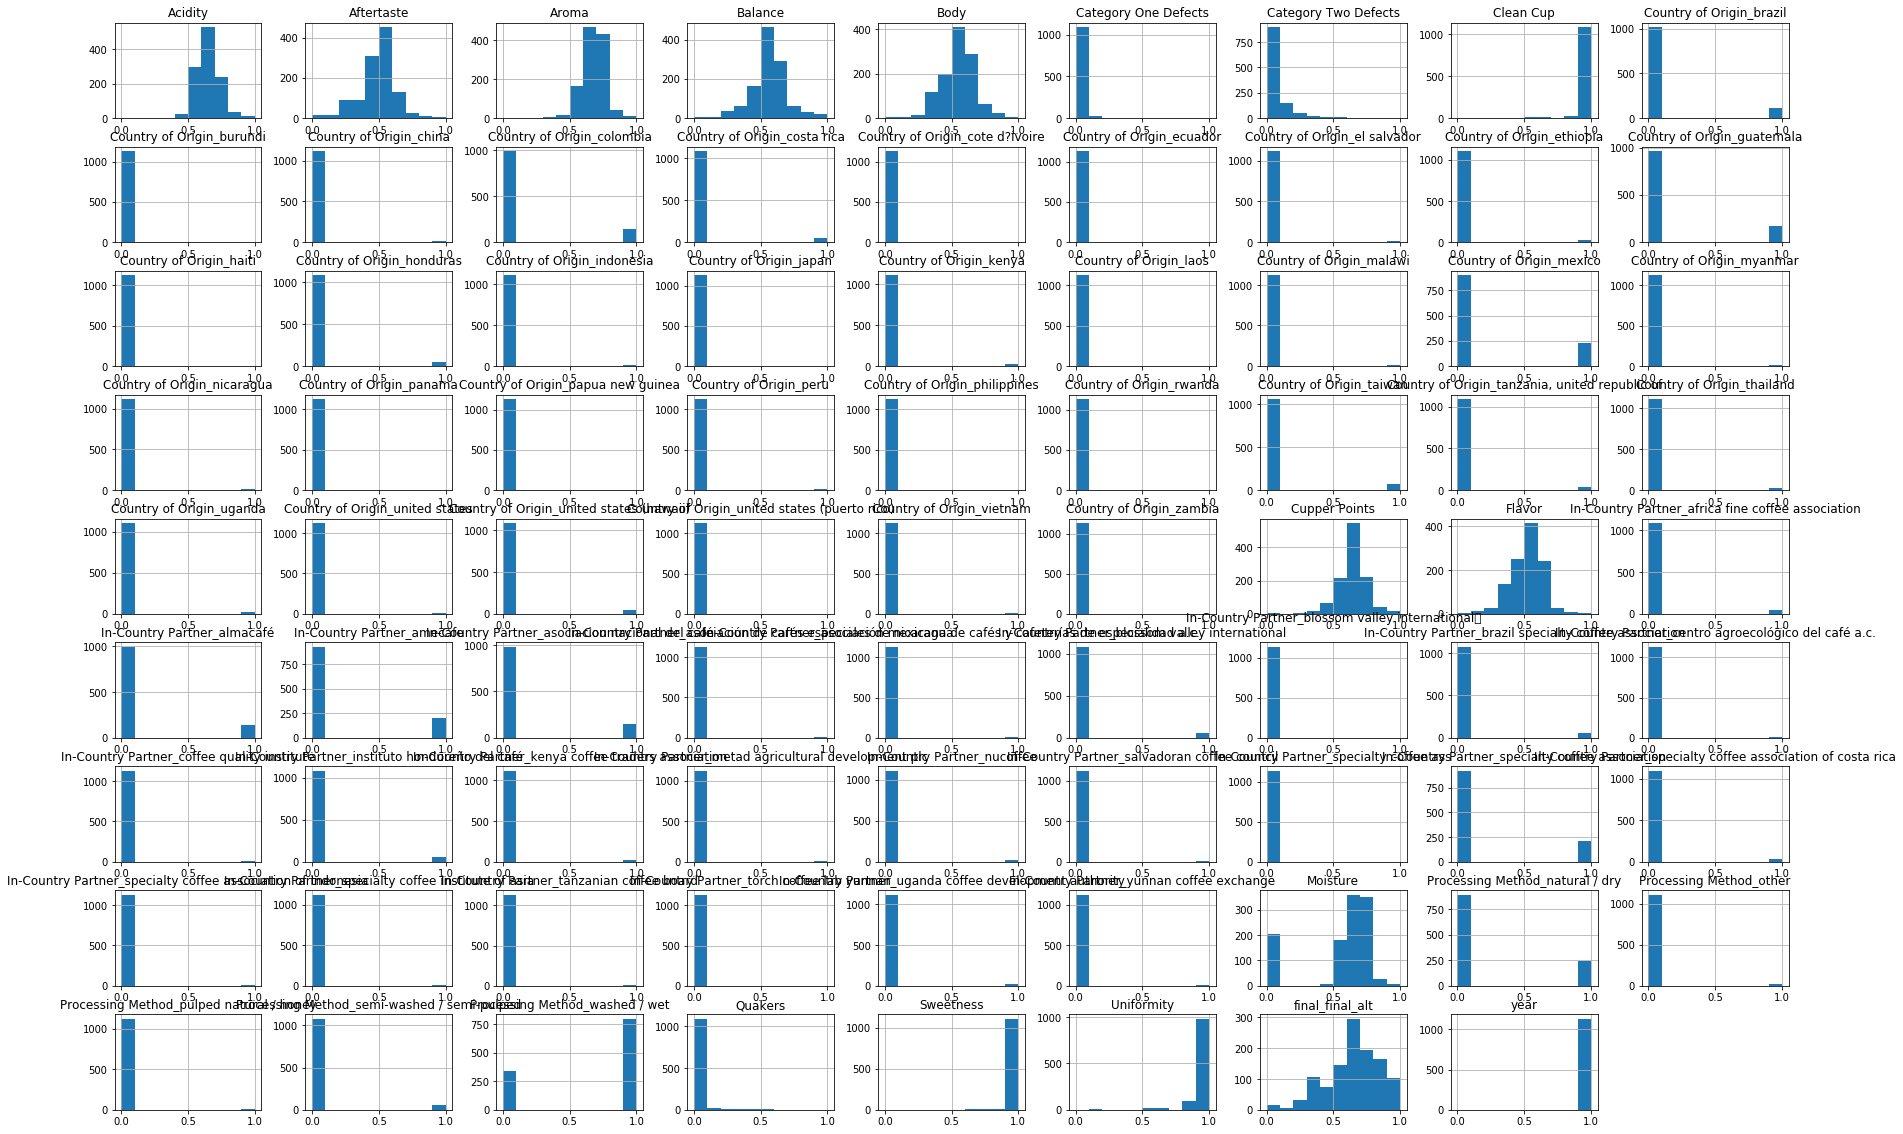

In [100]:
X.hist(figsize=(30,20));

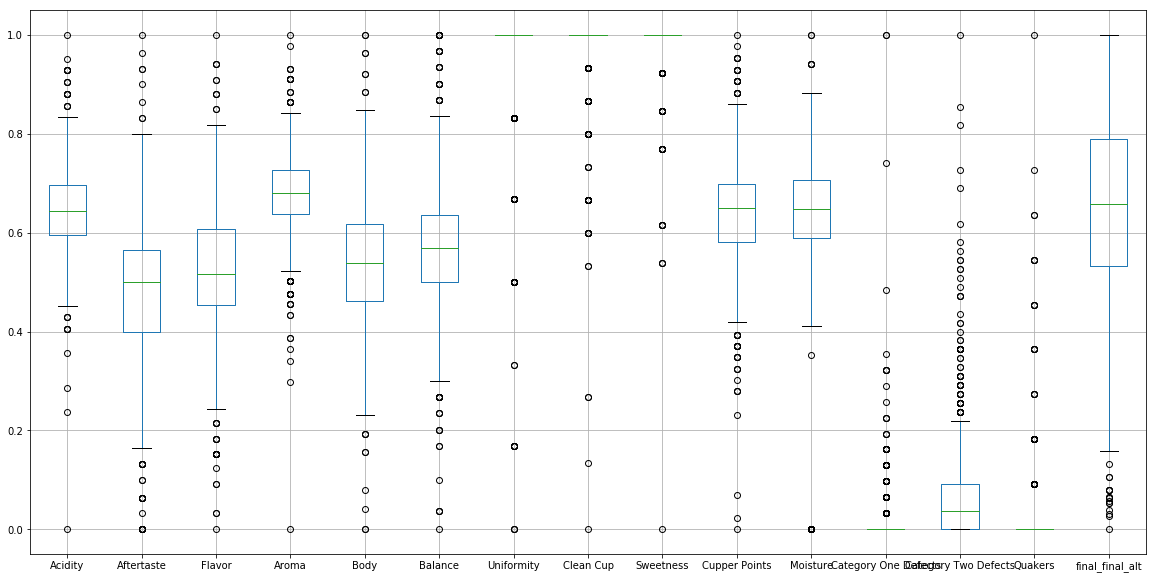

In [101]:
box_x = X[['Acidity', 'Aftertaste', 'Flavor', 'Aroma', 'Body', 'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points', 'Moisture', 'Category One Defects', 'Category Two Defects', 'Quakers', 'final_final_alt']]
box_x.boxplot(figsize=(20,10))

In [102]:
X.corr()

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Cupper Points,Moisture,Category One Defects,Quakers,Category Two Defects,year,final_final_alt,Country of Origin_brazil,Country of Origin_burundi,Country of Origin_china,Country of Origin_colombia,Country of Origin_costa rica,Country of Origin_cote d?ivoire,Country of Origin_ecuador,Country of Origin_el salvador,Country of Origin_ethiopia,Country of Origin_guatemala,Country of Origin_haiti,Country of Origin_honduras,Country of Origin_indonesia,Country of Origin_japan,Country of Origin_kenya,Country of Origin_laos,Country of Origin_malawi,Country of Origin_mexico,Country of Origin_myanmar,Country of Origin_nicaragua,Country of Origin_panama,Country of Origin_papua new guinea,Country of Origin_peru,Country of Origin_philippines,Country of Origin_rwanda,Country of Origin_taiwan,"Country of Origin_tanzania, united republic of",Country of Origin_thailand,Country of Origin_uganda,Country of Origin_united states,Country of Origin_united states (hawaii),Country of Origin_united states (puerto rico),Country of Origin_vietnam,Country of Origin_zambia,In-Country Partner_africa fine coffee association,In-Country Partner_almacafé,In-Country Partner_amecafe,In-Country Partner_asociacion nacional del café,In-Country Partner_asociación de cafés especiales de nicaragua,In-Country Partner_asociación mexicana de cafés y cafeterías de especialidad a.c.,In-Country Partner_blossom valley international,In-Country Partner_blossom valley international,In-Country Partner_brazil specialty coffee association,In-Country Partner_centro agroecológico del café a.c.,In-Country Partner_coffee quality institute,In-Country Partner_instituto hondureño del café,In-Country Partner_kenya coffee traders association,In-Country Partner_metad agricultural development plc,In-Country Partner_nucoffee,In-Country Partner_salvadoran coffee council,In-Country Partner_specialty coffee ass,In-Country Partner_specialty coffee association,In-Country Partner_specialty coffee association of costa rica,In-Country Partner_specialty coffee association of indonesia,In-Country Partner_specialty coffee institute of asia,In-Country Partner_tanzanian coffee board,In-Country Partner_torch coffee lab yunnan,In-Country Partner_uganda coffee development authority,In-Country Partner_yunnan coffee exchange,Processing Method_natural / dry,Processing Method_other,Processing Method_pulped natural / honey,Processing Method_semi-washed / semi-pulped,Processing Method_washed / wet
Aroma,1.000000,0.732760,0.682051,0.601956,0.564119,0.610915,0.159616,0.188462,0.090201,0.643242,-0.108642,-0.100324,0.022017,-0.197319,0.026778,0.176476,-0.033742,0.018346,0.031491,0.138101,0.081567,-0.013594,-0.005851,0.027491,0.202094,-0.035468,-0.078148,-0.098753,0.014714,0.018346,0.102508,-0.009584,0.002200,-0.163653,-0.070492,-0.113078,0.020750,0.074483,-0.010799,-0.042592,0.026089,-0.017448,-0.000593,-0.025347,0.171569,0.089467,-0.042832,0.016873,-0.021390,0.010603,0.033458,0.162220,-0.167871,-0.043136,-0.119691,0.044642,0.007706,-0.030048,-0.125970,0.011773,-0.091448,-0.107457,0.084194,0.165797,0.124547,-0.004835,0.010603,-0.030208,0.072607,0.031456,0.012796,-0.001832,0.019794,0.144141,0.064144,0.047143,-0.048980,-0.011091,0.032285,-0.038789
Flavor,0.732760,1.000000,0.855499,0.744316,0.674589,0.730189,0.230385,0.275240,0.156674,0.784633,-0.133725,-0.067657,0.026120,-0.237591,0.014502,0.127405,0.062181,0.014391,0.042009,0.124439,0.014245,-0.023075,0.014391,0.035688,0.246928,-0.042393,-0.092051,-0.106246,0.008771,0.021527,0.120976,-0.001341,-0.036077,-0.196833,-0.044588,-0.097806,0.020781,0.081293,-0.001900,-0.055285,0.036692,-0.033968,-0.053551,0.014295,0.111354,0.158833,-0.003635,0.005596,-0.007800,-0.038239,-0.041999,0.163608,-0.204925,-0.050285,-0.080819,0.034598,-0.009531,-0.023075,-0.009526,0.015984,-0.033154,-0.125084,0.095621,0.245895,0.097037,0.004176,0.021527,0.016424,-0.011153,0.004448,0.048930,-0.008527,0.009002,0.095970,0.070797,0.1

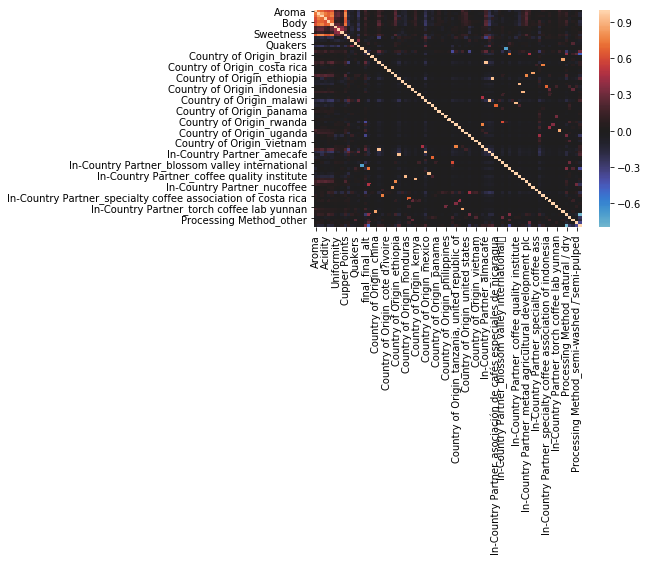

In [103]:
sns.heatmap(X.corr(), center = 0)

# Running a random test cause why not

In [98]:
#separate features into X and target to y
X = df.drop('target', axis=1)
y = df.target

In [99]:
# created training (75%) and test (25%) set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [13]:
# ran vanilla logistic regression model 
logreg = LogisticRegression(fit_intercept = False, C = 1e12) 

model_log = logreg.fit(X_train, y_train)
model_log

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [14]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [15]:
residuals = y_train - y_hat_train
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0.0    849
Name: target, dtype: int64
0.0    1.0
Name: target, dtype: float64


In [16]:
# found 96% accuracy score 
residuals = y_test - y_hat_test
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

 0.0    273
-1.0      9
 1.0      1
Name: target, dtype: int64
 0.0    0.964664
-1.0    0.031802
 1.0    0.003534
Name: target, dtype: float64


In [17]:
# varified class balance to ensure high accuracy was not attributed to a class imbalance problem created during data cleaning stage
df['target'].value_counts()

0.0    570
1.0    562
Name: target, dtype: int64

# Model Selection

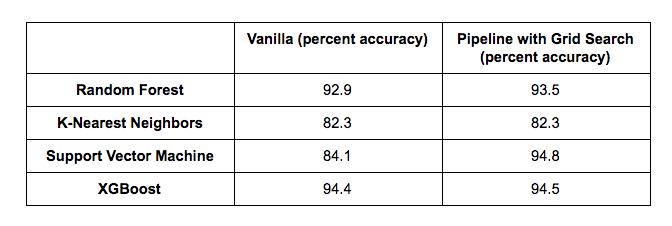

In [91]:
from IPython.display import Image
Image('model_selection.png')

### KNN

###### Vanilla KNN

In [26]:
clf1 = KNeighborsClassifier()
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, y_pred)

Precision Score: 0.7571428571428571
Recall Score: 0.8688524590163934
Accuracy Score: 0.823321554770318
F1 Score: 0.8091603053435115


###### KNN with pipeline and grid search

In [ ]:
# Construct pipeline
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

# Set grid search params
knn_param_grid = {
    'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]
}


# Construct grid search
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=knn_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_knn.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_knn.best_score_)

# Best params
print('\nBest params:\n', gs_knn.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=4 ..............................................
[CV] ............................... clf__n_neighbors=4, total=   0.0s
[CV] clf__n_neighbors=4 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.5s finished


In [ ]:
pipe_knn.get_params().keys()

dict_keys(['memory', 'steps', 'clf', 'clf__algorithm', 'clf__leaf_size', 'clf__metric', 'clf__metric_params', 'clf__n_jobs', 'clf__n_neighbors', 'clf__p', 'clf__weights'])

### SVM

###### Vanilla SVM

In [114]:
from sklearn.svm import SVC  
svclassifier = SVC()  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)
svclassifier.score(X_test, y_test)
print_metrics(y_test, y_pred)

Precision Score: 0.781021897810219
Recall Score: 0.8770491803278688
Accuracy Score: 0.8409893992932862
F1 Score: 0.8262548262548263


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


###### SVM with pipeline and grid search

In [ ]:
# Construct pipeline
pipe_svm = Pipeline([('clf', svm.SVC(random_state=123))])

# Set grid search params
param_grid_svm = [
#  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
  {'clf__C': [0.1, 1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf', 'linear']},
 ]

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.5s finished


### Random Forest

###### Vanilla Random Forest 

In [119]:
forest = RandomForestClassifier(random_state = 123)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
# print(forest.score(X_train, y_train))
# print(forest.score(X_test, y_test))
print_metrics(y_test, y_pred)

Precision Score: 0.925
Recall Score: 0.9098360655737705
Accuracy Score: 0.9293286219081273
F1 Score: 0.9173553719008265


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


###### Random Forest with pipeline and grid search

In [ ]:
# Construct pipeline
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state = 123))])

# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [100, 120],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[0.05 ,0.1, 0.2, 1, 2],  
   'clf__min_samples_split':[0.05 ,0.1, 0.2, 1.0, 2]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_sample

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1,

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_spli

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_sam

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.1, cl

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  2.2min finished


### XGBoost

###### Vanilla XGBoost

In [23]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

# print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
# print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
print_metrics(y_test, val_preds)

Precision Score: 0.9206349206349206
Recall Score: 0.9508196721311475
Accuracy Score: 0.9434628975265018
F1 Score: 0.9354838709677418


###### XGBoost with pipeline and grid search

In [14]:
# Construct pipeline
pipe_xg = Pipeline([('clf', xgb.XGBClassifier(random_state = 123))])

# Set grid search params
xgboost_param_grid ={
    "clf__learning_rate": [0.1],
    'clf__max_depth': [5, 6, 7],
    'clf__min_child_weight': [1, 5, 10],
    'clf__subsample': [ 0.7, 1],
    'clf__n_estimators': [5, 30, 80]
}

# Construct grid search
gs_xg = GridSearchCV(estimator=pipe_xg,
            param_grid=xgboost_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_xg.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_xg.best_score_)

# Best params
print('\nBest params:\n', gs_xg.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=5, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=5, clf__subsample=0.7, total=   0.0s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=5, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=5, clf__subsample=0.7, total=   0.0s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=5, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=5, clf__subsample=0.7, total=   0.0s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=5, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=5, clf__subsa

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=1, total=   0.2s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf_

[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=5, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, 

[CV] clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=5, clf__n_estimators=30, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=5, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=5, clf__n_estimators=30, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=5, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=5, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=5, clf__n_estimators=30, clf__subsample=1, total=   0.2s
[CV] clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=5, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf__max_depth=6, clf__min_child_weight=5, clf__n_estimators=30, clf__subsample=1, total=   0.1s
[CV] clf__learning_rate=0.1, clf__ma

[CV]  clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=1, total=   0.2s
[CV] clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=1, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf_

[CV]  clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=0.7 
[CV]  clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=0.7, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1, total=   0.1s
[CV] clf__learning_rate=0.1, clf__max_depth=7, clf__min_child_weight=10, clf__n_estimators=30, clf__subsample=1 
[CV]  clf__learning_rate=0.1, 

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:   20.6s finished


Best accuracy: 0.945

Best params:
 {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__min_child_weight': 1, 'clf__n_estimators': 80, 'clf__subsample': 0.7}


# PCA

In [ ]:
#correlation heatmap prior to PCA 
# sns.heatmap(X.corr(), center=0)

Text(0, 0.5, 'Explained Variance')

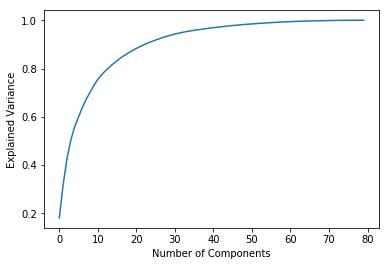

In [23]:
#choosing number of features to include based on explained variable 
pca = PCA(80)
pca_full = pca.fit(X)

plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [13]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=20)
pca_2 = PCA(n_components=40)
pca_3 = PCA(n_components=60)

principalComponents = pca_1.fit_transform(X)
principalComponents = pca_2.fit_transform(X)
principalComponents = pca_3.fit_transform(X)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

pca = PCA(n_components=80)
principalComponents = pca.fit_transform(X)
print(np.sum(pca.explained_variance_ratio_))

0.8748344764801131
0.9672083148897148
0.993571009755971
0.9999999999999998


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


5 0.911660777385159
6 0.911660777385159
7 0.9187279151943463


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


8 0.9187279151943463
9 0.911660777385159
10 0.9293286219081273
11 0.9328621908127208


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

12 0.9328621908127208
13 0.9293286219081273


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


14 0.9293286219081273


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


15 0.9293286219081273
20 0.911660777385159


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


25 0.9187279151943463


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


30 0.9045936395759717


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


35 0.8939929328621908
40 0.8939929328621908


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


45 0.8869257950530035


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


50 0.8869257950530035


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


55 0.8833922261484098


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


60 0.8798586572438163


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


65 0.8657243816254417


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


70 0.8692579505300353


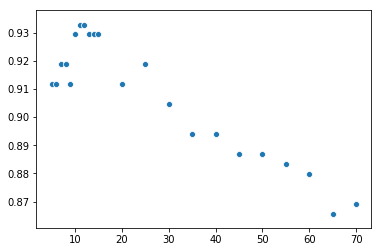

In [14]:
components = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
y_axis = []
for component in components:
    svclassifier = SVC()  
    svclassifier.fit(X_train.iloc[:,:component], y_train) 
    y_pred = svclassifier.predict(X_test.iloc[:,:component])
    y_axis.append(svclassifier.score(X_test.iloc[:,:component], y_test))
    print(component, svclassifier.score(X_test.iloc[:,:component], y_test))

sns.scatterplot(x = components, y = y_axis)

    

11 and 12 components provides the most accuracy.

In [15]:
pca = PCA(n_components = 40)
principal_components = pca.fit_transform(X)

In [16]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape, X_test_pca.shape)

(849, 40) (283, 40)


In [17]:
# Construct pipeline
pipe_svm = Pipeline([('clf', svm.SVC(random_state=123))])

# Set grid search params
param_grid_svm = [
#  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
  {'clf__C': [0.1, 1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf', 'linear']},
 ]

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train_pca, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    3.1s finished


# Best Model - SVM with linear kernel, gamma = .001, C = 10

In [28]:
svclassifier = SVC(kernel = 'linear', gamma = 0.001, C = 10)  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)
svclassifier.score(X_test, y_test)

0.9646643109540636

###### Evaluation Metrics

In [30]:
print_metrics(y_test, y_pred)

Precision Score: 0.9516129032258065
Recall Score: 0.9672131147540983
Accuracy Score: 0.9646643109540636
F1 Score: 0.959349593495935


In [31]:
print(confusion_matrix(y_test, y_pred))

[[155   6]
 [  4 118]]


In [32]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

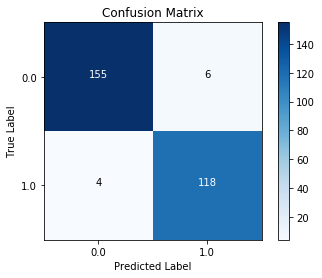

In [35]:
show_cf(y_test, y_pred)

###### Investigating Model Coefficients

In [38]:
#finding feature coefficients
svclassifier.coef_

array([[ 8.11615777e+00,  7.04558691e+00,  7.70064403e+00,
         7.88771348e+00,  4.62171047e+00,  5.34470053e+00,
         7.25027956e+00,  8.76090254e+00,  9.32464244e+00,
         7.95905545e+00, -3.57675824e-02,  2.13957390e+00,
        -2.80615337e+00,  1.11041116e+00,  1.06649069e-01,
         7.54451450e-01, -4.70240764e-01,  0.00000000e+00,
        -3.06428463e-01,  3.63428297e-01, -6.36262128e-01,
         0.00000000e+00,  0.00000000e+00,  1.69094909e-01,
         0.00000000e+00, -1.35279969e+00,  0.00000000e+00,
        -3.04969864e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  4.34227621e-01, -2.36953322e-01,
        -2.44416686e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.02989158e+00,
         3.34204121e-03,  0.00000000e+00,  4.70137554e-01,
        -2.83686288e-01,  1.03698887e+00,  3.99662889e-01,
         7.26589948e-01,  5.96411617e-01,  0.00000000e+00,
         4.45790029e-01,  0.00000000e+00, -2.26336194e-0

In [39]:
coef = [ 8.11615777e+00,  7.04558691e+00,  7.70064403e+00,
         7.88771348e+00,  4.62171047e+00,  5.34470053e+00,
         7.25027956e+00,  8.76090254e+00,  9.32464244e+00,
         7.95905545e+00, -3.57675824e-02,  2.13957390e+00,
        -2.80615337e+00,  1.11041116e+00,  1.06649069e-01,
         7.54451450e-01, -4.70240764e-01,  0.00000000e+00,
        -3.06428463e-01,  3.63428297e-01, -6.36262128e-01,
         0.00000000e+00,  0.00000000e+00,  1.69094909e-01,
         0.00000000e+00, -1.35279969e+00,  0.00000000e+00,
        -3.04969864e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  4.34227621e-01, -2.36953322e-01,
        -2.44416686e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.02989158e+00,
         3.34204121e-03,  0.00000000e+00,  4.70137554e-01,
        -2.83686288e-01,  1.03698887e+00,  3.99662889e-01,
         7.26589948e-01,  5.96411617e-01,  0.00000000e+00,
         4.45790029e-01,  0.00000000e+00, -2.26336194e-01,
        -2.38733802e-01, -5.96627021e-01,  1.11653855e+00,
         0.00000000e+00,  1.70085330e-01, -7.65327924e-02,
         0.00000000e+00,  5.41012619e-01,  0.00000000e+00,
         0.00000000e+00, -5.66120838e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.69094909e-01,
         0.00000000e+00, -4.85877179e-01,  2.21676745e-01,
         0.00000000e+00, -3.36620088e-01, -2.94303416e-01,
         0.00000000e+00,  3.99662889e-01, -3.06428463e-01,
        -3.73374255e-01, -2.62080489e-01,  1.02309901e+00,
        -2.88644540e-01, -9.89997220e-02]

In [73]:
#finding most important features (helpful link to understand feature meaning with SVM https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights)
impt_list_c = []
impt_list_f = []
for i in range(len(coef)): 
    if abs(coef[i]) > 1:
        impt_coef = abs(coef[i])
        impt_feat = df.columns[i]
        impt_list_c.append(impt_coef)
        impt_list_f.append(impt_feat)
        print(impt_coef, impt_feat)

8.11615777 Aroma
7.04558691 Flavor
7.70064403 Aftertaste
7.88771348 Acidity
4.62171047 Body
5.34470053 Balance
7.25027956 Uniformity
8.76090254 Clean Cup
9.32464244 Sweetness
7.95905545 Cupper Points
2.1395739 Category One Defects
2.80615337 Quakers
1.11041116 Category Two Defects
1.35279969 Country of Origin_ethiopia
1.02989158 Country of Origin_papua new guinea
1.03698887 Country of Origin_tanzania, united republic of
1.11653855 In-Country Partner_amecafe
1.02309901 Processing Method_other


In [56]:
impt_list_c

[8.11615777,
 7.04558691,
 7.70064403,
 7.88771348,
 4.62171047,
 5.34470053,
 7.25027956,
 8.76090254,
 9.32464244,
 7.95905545,
 2.1395739,
 2.80615337,
 1.11041116,
 1.35279969,
 1.02989158,
 1.03698887,
 1.11653855,
 1.02309901]

<BarContainer object of 18 artists>

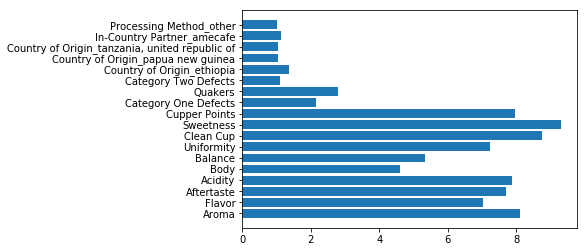

In [59]:
fig, ax = plt.subplots()
ax.barh(impt_list_f, impt_list_c)

In [ ]:
fig, ax = plt.subplots()
y_pos = np.arange(len(coef))
ax.barh(y_pos, coef)

In [60]:
impt_list_f

['Aroma',
 'Flavor',
 'Aftertaste',
 'Acidity',
 'Body',
 'Balance',
 'Uniformity',
 'Clean Cup',
 'Sweetness',
 'Cupper Points',
 'Category One Defects',
 'Quakers',
 'Category Two Defects',
 'Country of Origin_ethiopia',
 'Country of Origin_papua new guinea',
 'Country of Origin_tanzania, united republic of',
 'In-Country Partner_amecafe',
 'Processing Method_other']

###### Run our best model with our most important features (absolute value of coefficient values > 1

In [68]:
X_impt = df[['Aroma',
 'Flavor',
 'Aftertaste',
 'Acidity',
 'Body',
 'Balance',
 'Uniformity',
 'Clean Cup',
 'Sweetness',
 'Cupper Points',
 'Category One Defects',
 'Quakers',
 'Category Two Defects',
 'Country of Origin_ethiopia',
 'Country of Origin_papua new guinea',
 'Country of Origin_tanzania, united republic of',
 'In-Country Partner_amecafe',
 'Processing Method_other']]

y_impt = df.target

X_impt_train, X_impt_test, y_impt_train, y_impt_test = train_test_split(X_impt, y_impt, random_state=0)

In [71]:
svclassifier = SVC(kernel = 'linear', gamma = 0.001, C = 10)  
svclassifier.fit(X_impt_train, y_impt_train) 
y_pred = svclassifier.predict(X_impt_test)
svclassifier.score(X_impt_test, y_impt_test)

0.9787985865724381

In [74]:
print_metrics(y_test, y_pred)

Precision Score: 0.9754098360655737
Recall Score: 0.9754098360655737
Accuracy Score: 0.9787985865724381
F1 Score: 0.9754098360655737


###### Investigate most important features (absolute value of coefficients >2) 

In [75]:
impt_list_c = []
impt_list_f = []
for i in range(len(coef)): 
    if abs(coef[i]) > 2:
        impt_coef = abs(coef[i])
        impt_feat = df.columns[i]
        impt_list_c.append(impt_coef)
        impt_list_f.append(impt_feat)
        print(impt_coef, impt_feat)

8.11615777 Aroma
7.04558691 Flavor
7.70064403 Aftertaste
7.88771348 Acidity
4.62171047 Body
5.34470053 Balance
7.25027956 Uniformity
8.76090254 Clean Cup
9.32464244 Sweetness
7.95905545 Cupper Points
2.1395739 Category One Defects
2.80615337 Quakers


<BarContainer object of 12 artists>

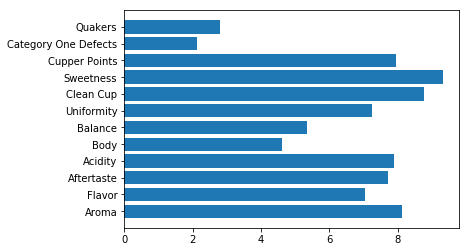

In [76]:
fig, ax = plt.subplots()
ax.barh(impt_list_f, impt_list_c)

In [77]:
impt_list_f

['Aroma',
 'Flavor',
 'Aftertaste',
 'Acidity',
 'Body',
 'Balance',
 'Uniformity',
 'Clean Cup',
 'Sweetness',
 'Cupper Points',
 'Category One Defects',
 'Quakers']

In [78]:
X_impt = df[['Aroma',
 'Flavor',
 'Aftertaste',
 'Acidity',
 'Body',
 'Balance',
 'Uniformity',
 'Clean Cup',
 'Sweetness',
 'Cupper Points',
 'Category One Defects',
 'Quakers']]

X_impt_train, X_impt_test, y_impt_train, y_impt_test = train_test_split(X_impt, y_impt, random_state=0)

In [79]:
svclassifier = SVC(kernel = 'linear', gamma = 0.001, C = 10)  
svclassifier.fit(X_impt_train, y_impt_train) 
y_pred = svclassifier.predict(X_impt_test)
svclassifier.score(X_impt_test, y_impt_test)

0.9858657243816255

In [80]:
print_metrics(y_test, y_pred)

Precision Score: 0.9758064516129032
Recall Score: 0.9918032786885246
Accuracy Score: 0.9858657243816255
F1 Score: 0.983739837398374


# Conclusions

Our selected model performed with high accuracy to predict if coffee is above or below the median quality score (82.5 on a scale of 1-100). Our model can be used by a cafe to predict if the quality score is above or below the mdeian, ultimately recommending whether or not to sell a given coffee to their customers. Of course, there are limitations to the model. The most important features we determined include ones that require an objective evaluation of the coffee (ie. aroma, flavor, acidity), so it would be necessary to first evaluate these features before being able to use the model to predict the quality. 

# Next Steps

###### Investigate a different target variable
* Based on the quality score distributions, we found the best way to initially approach modeling the data would be classifying coffee that scored below or above the median. Very few data points scored very high and very few scored very low, so we found the median to be a good representation of a "good" or "bad" cup of coffee. Ultimately, it would be interesting to classify a "very good", "okay", and "very bad" cup of coffee. 

###### Incorporating additional data
* We initially incorporated price data based on harvest year and country, but based on the time and missing data for particular countries/years, we did not ultimately include this data in our model. As a next step, we would like to fill in this missing data so it can be incorporated during the model stage 
* Find other country metadata that can be incorporated based on country of origin 